In [1]:
# General stuff
import os
import re
import time
import warnings
import math
import sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from subprocess import Popen, PIPE
from os.path import join as opj
from IPython.core.debugger import Tracer
from nilearn.decomposition import CanICA,DictLearning
from sklearn.decomposition import DictionaryLearning

# sklearn stuff
from sklearn.decomposition import TruncatedSVD,FastICA,SparsePCA,MiniBatchSparsePCA
from sklearn.utils.extmath import randomized_svd
from sklearn.linear_model import Ridge
from sklearn.decomposition import dict_learning_online
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import scale
import sklearn.metrics.cluster as metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster.hierarchical import _hc_cut # Internal function to cut ward tree, helps speed up things a lot
from sklearn.utils import resample
from sklearn.model_selection import KFold

# personal functions
from importlib import reload
import fsutils as fs
reload(fs)

if os.path.exists('/data1/vbeliveau/'):
    # On NRU server
    cluster_code='/data1/vbeliveau/5HT_clustering'
    cluster_data='/data1/vbeliveau/5HT_clustering_data'
    subjects_dir='/usr/local/nru/freesurfer/subjects'
elif os.path.exists('C:/Users/vbeliveau/'):
    # On laptop
    cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
    cluster_data='C:/Users/vbeliveau/Documents/5HT_clustering_data'
    subjects_dir='C:/Users/vbeliveau/Downloads/'
else:
    raise ValueError('Unknown location')
    
# Load local version of nilearn
if os.path.exists('/data1/vbeliveau/'):
    sys.path.append('/data1/vbeliveau/nilearn')
    import mynilearn.decomposition as dcm 
    reload(dcm)
elif os.path.exists('C:/Users/vbeliveau/'):
    sys.path.append('C:/Users/vbeliveau/Downloads/nilearn-master')
    import mynilearn.decomposition as dcm
    reload(dcm)
else:
    raise ValueError('Unknown location')
    
# Analysis directories
surf_data=opj(cluster_data,'surf_data')
fs.assert_dir(surf_data)
BPnd_data=opj(cluster_data,'BPnd')
fs.assert_dir(BPnd_data)
MFA_data=opj(cluster_data,'MFA')
MFA_preproc=opj(MFA_data,'preproc')
fs.assert_dir(MFA_data)
fs.assert_dir(MFA_preproc)

info_path=opj(cluster_code,'info_alltracers_base_healthy_hrrt.mat')
hemi_type=['lh','rh']

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
petID=[item for subl in info['petID'] for subsubl in subl for item in subsubl]

In [5]:
# Sync data directories
# nrudata.nru.dk/data1 has been mapped to Z:
from dirsync import sync
a=sync('Z:/vbeliveau/5HT_clustering_data',cluster_data,'sync',verbose=True,create=True)

Processing cumi


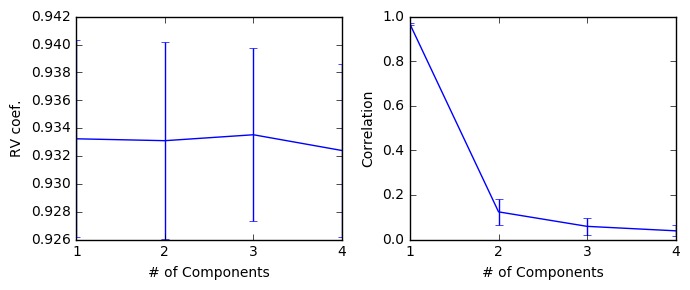

Processing dasb


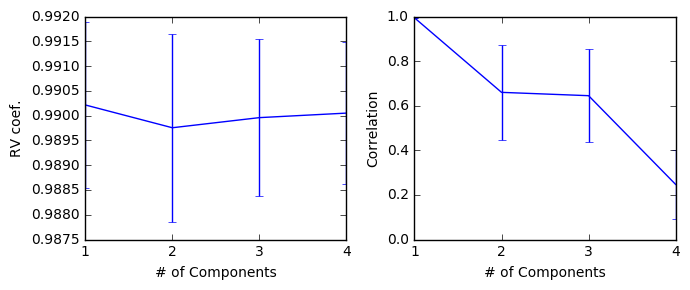

Processing sb


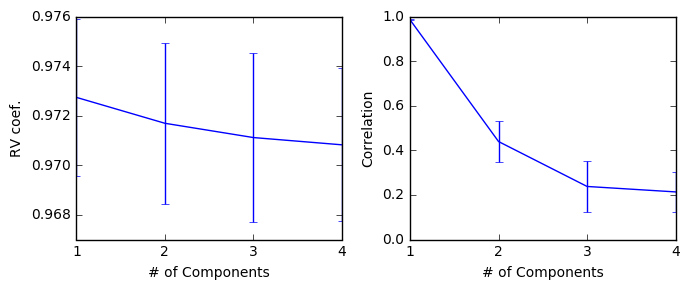

Processing az


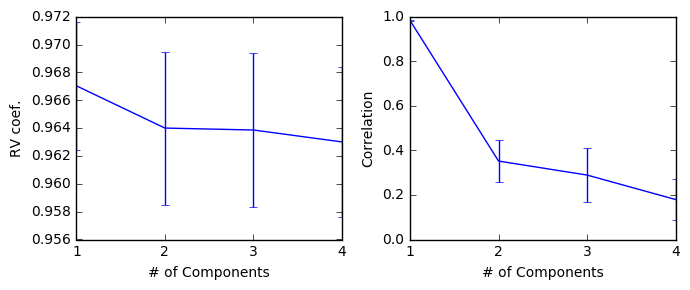

Processing C36


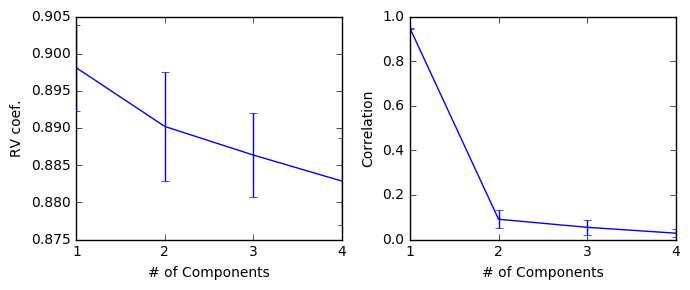

In [57]:
# Evaluate stability and reproducibility of BPnd PCA

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='10'
hemi_type=['lh','rh']
K=4
N_iter=100

for tracer,nt in zip(tracers,np.arange(0,len(tracers))+1):
    
    print('Processing '+tracer)
    
    tmp_data=np.empty(len(hemi_type),dtype=object)
    for hemi,nh in zip(hemi_type,np.arange(0,len(hemi_type))):
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        tmp_data[nh]=fs.load_surf_data(fname,mask=fmask)
    tmp_data=np.vstack(tmp_data)
    data=np.ndarray(tmp_data.shape[1],dtype=object)
    for nc in np.arange(0,tmp_data.shape[1]):
        data[nc]=tmp_data[:,nc]

    stabil=np.ndarray(K,dtype=object)
    for nk in np.arange(0,K):
        def func(data):
            U,S,_=randomized_svd(np.column_stack(data),nk+1)
            return (U.T * S[:, np.newaxis]).T

        stabil[nk],_=fs.split_half(data,func,n_iter=N_iter,
                                   repro_metric=None,
                                   stabil_metric='rv')
        
    def func(data):
        U,S,_=randomized_svd(np.column_stack(data),K)
        return (U.T * S[:, np.newaxis]).T

    _,repro=fs.split_half(data,func,n_iter=N_iter,
                               repro_metric='corr',
                               stabil_metric=None)
    
    x_range=np.arange(0,K)+1
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    plt.errorbar(x_range,
                 [stabil_k.mean() for stabil_k in stabil],
                 yerr=[stabil_k.std() for stabil_k in stabil])
    plt.xticks(x_range)
    
    plt.xlabel('# of Components')
    plt.ylabel('RV coef.')

    plt.subplot(1,2,2)
    plt.errorbar(x_range,
                 repro.mean(axis=0),
                 yerr=repro.std(axis=0))
    plt.xticks(x_range)
    plt.axis([x_range[0],x_range[-1],0,1])
    plt.xlabel('# of Components')
    plt.ylabel('Correlation')

    plt.tight_layout()
    plt.show()

In [ ]:
# Evaluate reproducibility of DictLearning on BPnd

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='10'
hemi_type=['lh','rh']
K_range=np.arange(2,20)
N_iter=100

print('Loading data')
tmp_data=np.ndarray(len(tracers),dtype=object)
groups=[]
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):    
    hemi_data=np.empty(len(hemi_type),dtype=object)
    for hemi,nh in zip(hemi_type,np.arange(0,len(hemi_type))):
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        hemi_data[nh]=fs.load_surf_data(fname,mask=fmask)
    tmp_data[nt]=np.vstack(hemi_data)
    groups=np.append(groups,np.repeat(tracer,tmp_data[nt].shape[1]))
tmp_data=np.column_stack(tmp_data)                     
data=np.ndarray(tmp_data.shape[1],dtype=object)
for nc in np.arange(0,tmp_data.shape[1]):
    data[nc]=tmp_data[:,nc]
                     
stabil=np.ndarray(len(K_range),dtype=object)
repro=np.ndarray(len(K_range),dtype=object)
for K,nk in zip(K_range,np.arange(0,len(K_range))):
    
    print('Processing K='+str(K))
    
    def func(data,args):
        groups=args
        group_types=np.unique(groups)
        MFA_components=np.ndarray(len(group_types),dtype=object)
        for group,ng in zip(group_types,np.arange(0,len(group_types))):
            U,S,_=randomized_svd(np.column_stack(data[groups==group]),1)
            MFA_components[ng]=(U.T * S[:, np.newaxis]).T
        MFA_components=np.column_stack(MFA_components).T

        ica=FastICA(n_components=K,fun='cube',max_iter=2000)
        ica.fit(MFA_components)
        S = (ica.components_ ** 2).sum(axis=1)
        S[S == 0] = 1
        ica.components_ /= S[:, np.newaxis]

        ridge = Ridge(fit_intercept=None, alpha=1e-8)
        ridge.fit(ica.components_.T, np.asarray(MFA_components.T))
        loadings = ridge.coef_.T
        S = np.sqrt(np.sum(loadings ** 2, axis=0))
        S[S == 0] = 1
        loadings /= S[np.newaxis, :]

        n_features=MFA_components.shape[1]
        batch_size=20
        n_iter = ((n_features - 1) // batch_size + 1)
        components, _ = dict_learning_online(
                MFA_components.T, K, alpha=10, n_iter=n_iter,
                batch_size=20, method='cd',
                dict_init=loadings, return_code=True, shuffle=True)
        components=components.T

        S = np.sqrt(np.sum(components ** 2, axis=1))
        S[S == 0] = 1
        components /= S[:, np.newaxis]

        for comp in components:
            if np.sum(comp > 0) < np.sum(comp < 0):
                comp *= -1 
        
        return components.T
    
    stabil[nk],repro[nk]=fs.split_half(data,func,n_iter=N_iter,
                                  groups=groups,
                                  repro_metric='cos',stabil_metric='congr')
    
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.errorbar(K_range,
             [stabil_k.mean() for stabil_k in stabil],
             yerr=[stabil_k.std() for stabil_k in stabil])
plt.xticks(K_range)
plt.xlabel('# of Components')
plt.ylabel('Congr coef.')

plt.subplot(1,2,2)
plt.errorbar(K_range,
             [np.nanmean(repro_k,axis=1).mean() for repro_k in repro],
             yerr=[np.nanmean(repro_k,axis=1).std() for repro_k in repro])
plt.xticks(K_range)
plt.axis([K_range[0],K_range[-1],0,1])
plt.xlabel('# of Components')
plt.ylabel('Cos')

plt.tight_layout()
plt.show()

Loading data
Processing K=2


In [43]:
# Perform dictionary learning across all BPnd concatenated into tracers

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='10'
hemi_type=['lh','rh']

K=5
N_repeat=10
minsize=100

dest=BPnd_data+'/DictLearning_tests'
fs.assert_dir(dest)

print('Loading data')
data=np.ndarray(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):    
    hemi_data=np.empty(len(hemi_type),dtype=object)
    for hemi,nh in zip(hemi_type,np.arange(0,len(hemi_type))):
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        hemi_data[nh]=fs.load_surf_data(fname,mask=fmask)
    data[nt]=np.vstack(hemi_data)
    
print('Processing K='+str(K))

MFA_components=np.ndarray(len(tracers),dtype=object)
for nt in np.arange(0,len(tracers)):
    U,S,_=randomized_svd(np.column_stack(data[nt].T),1)
    MFA_components[nt]=(U.T * S[:, np.newaxis]).T
MFA_components=np.column_stack(MFA_components).T

ica=FastICA(n_components=K,fun='cube',max_iter=2000)
ica.fit(MFA_components)
S = (ica.components_ ** 2).sum(axis=1)
S[S == 0] = 1
ica.components_ /= S[:, np.newaxis]

ridge = Ridge(fit_intercept=None, alpha=1e-6)
ridge.fit(ica.components_.T, np.asarray(MFA_components.T))
loadings = ridge.coef_.T
S = np.sqrt(np.sum(loadings ** 2, axis=0))
S[S == 0] = 1
loadings /= S[np.newaxis, :]

n_features=MFA_components.shape[1]
batch_size=20
n_iter = ((n_features - 1) // batch_size + 1)

for nr in np.arange(0,N_repeat):
    components,_ = dict_learning_online(
        MFA_components.T, K, alpha=15, n_iter=n_iter,
        batch_size=20, method='cd',
        dict_init=loadings, return_code=True, shuffle=True)
    components = components[:,np.abs(np.sum(components,axis=0))>0]
    print('Components after pruning: '+str(components.shape[1]))
    
    # Split components spatially
    split_components=np.ndarray(len(hemi_type),dtype=object)
    nstart=0
    nstop=0
    for hemi,nh in zip(hemi_type,np.arange(0,len(hemi_type))):
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fneigh=opj(surf_data,'neigh.'+targ+'.'+hemi+'.matrix')
        nstart=nstop
        ma,_,N=fs.load_mask(fmask)
        nstop=nstop+len(ma)
        surf=components[np.arange(nstart,nstop),:]
        cluster=fs.split_clusters(fneigh,surf)
        split_components[nh]=np.zeros([components.shape[0],cluster.shape[1]],dtype=float)
        split_components[nh][np.arange(nstart,nstop),:]=cluster
    split_components=np.column_stack(split_components)
    
    # Prune small components
    split_components=split_components[:,np.sum(split_components!=0,axis=0)>minsize]
    
    K=split_components.shape[1]
    print('Components after split: '+str(K))
    
    fname=[opj(dest,'N'+str(nr)+'.'+targ +
               '.' +hemi+'.sm' + sm + '.nii.gz') 
       for hemi in hemi_type]
    fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
    fs.save_surf_data(split_components,fname,mask=fmask)
    
    # Update loadings
    ridge = Ridge(fit_intercept=None, alpha=1e-6)
    ridge.fit(split_components, np.asarray(MFA_components.T))
    loadings = ridge.coef_.T
    S = np.sqrt(np.sum(loadings ** 2, axis=0))
    S[S == 0] = 1
    loadings /= S[np.newaxis, :]

components=split_components
S = np.sqrt(np.sum(components ** 2, axis=1))
S[S == 0] = 1
components /= S[:, np.newaxis]

for comp in components:
    if np.sum(comp > 0) < np.sum(comp < 0):
        comp *= -1

fname=[opj(dest,targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
       for hemi in hemi_type]
fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
fs.save_surf_data(split_components,fname,mask=fmask)


Loading data
Processing K=5
Components after pruning: 4
Components after split: 16
Components after pruning: 10
Components after split: 37
Components after pruning: 19
Components after split: 46
Components after pruning: 18
Components after split: 58
Components after pruning: 21
Components after split: 51
Components after pruning: 19
Components after split: 51
Components after pruning: 20
Components after split: 56
Components after pruning: 22
Components after split: 56
Components after pruning: 19
Components after split: 54
Components after pruning: 17
Components after split: 48


In [ ]:
targ='fsaverage5'
cluster=np.ndarray(len(hemi_type),dtype=object)
nstart=0
nstop=0
for hemi in hemi_type:    
    fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
    fneigh=opj(surf_data,'neigh.'+targ+'.'+hemi+'.matrix')
    nstart=nstop
    ma,_,N=fs.load_mask(fmask)
    nstop=nstop+len(ma)
    surf=components[:,np.arange(nstart,nstop)].T
    cluster=fs.split_clusters(fneigh,surf)
    fname=opj(BPnd_data,'test.'+hemi+'.nii.gz')
    fs.save_surf_data(cluster,fname,mask=fmask)